In [24]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import NearestNeighbors


In [3]:
import sys
sys.path.insert(1, '/home/dtd/Documents/interpretable_machine_learning/Source Code/my_work/lib')
import propensity_score_estimator as pse

In [39]:
# random numbers from uniform distribution
def logit(X1,X2,X3,X4):
    return sigmoid(-X1 + 0.5*X2 - 0.24*X3 - 0.1*X4)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def mean_function(A,X1,X2,X3,X4):
    return np.mean(200 + A*(10+27.4*X1 + 13.7*X2 + 13.7*X3 + 13.7*X4))

n = 10000
start = 10
width = 20

random_state = 42
X1 = norm.rvs(loc=0, scale=1, size=n, random_state=1)
X2 = norm.rvs(loc=0, scale=1, size=n, random_state=2)
X3 = norm.rvs(loc=0, scale=1, size=n, random_state=3)
X4 = norm.rvs(loc=0, scale=1, size=n, random_state=4)
X = np.array([X1, X2, X3, X4]).T
A = logit(X1,X2,X3,X4)
A[A >= 0.5] = 1
A[A < 0.5] = 0
A = A.reshape(n,1)
loc_y = mean_function(A,X1,X2,X3,X4)
scale_y = 1
Y = norm.rvs(loc=loc_y, scale=scale_y, size=n, random_state=random_state)

In [48]:
A_pos = np.full((n, 1), 1)
A_neg = np.full((n, 1), 0)
loc_y_pos = mean_function(A_pos,X1,X2,X3,X4)
loc_y_neg = mean_function(A_neg,X1,X2,X3,X4)

Y_pos = norm.rvs(loc=loc_y_pos, scale=1, size=n, random_state=random_state)
Y_neg = norm.rvs(loc=loc_y_neg, scale=1, size=n, random_state=random_state)

In [47]:
np.mean(Y_pos) - np.mean(Y_neg)

9.64551207826483

In [6]:
df = pd.DataFrame()
df['Y'] = Y
df['A'] = A
df['X1'] = X1
df['X2'] = X2
df['X3'] = X3
df['X4'] = X4

[Text(0, 0.5, 'Frequency'), Text(0.5, 0, 'Uniform Distribution ')]

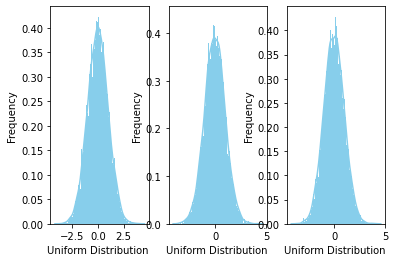

In [11]:
# f, axes = plt.subplots(3, 2)
f, axes = plt.subplots(ncols=3)

ax = sns.distplot(X1,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1}, ax=axes[0])
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

ax = sns.distplot(X2,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1}, ax=axes[1])
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

ax = sns.distplot(X3,
                  bins=100,
                  kde=True,
                  color='skyblue',
                  hist_kws={"linewidth": 15,'alpha':1}, ax=axes[2])
ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

# ax = sns.distplot(X4,
#                   bins=100,
#                   kde=True,
#                   color='skyblue',
#                   hist_kws={"linewidth": 15,'alpha':1}, ax=axes[1,1])
# ax.set(xlabel='Uniform Distribution ', ylabel='Frequency')

# ax = sns.distplot(A,
#                   bins=100,
#                   kde=True,
#                   color='skyblue',
#                   hist_kws={"linewidth": 15,'alpha':1}, ax=axes[2,0])
# ax.set(xlabel='Treatment ', ylabel='Frequency')

# ax = sns.distplot(Y,
#                   bins=100,
#                   kde=True,
#                   color='skyblue',
#                   hist_kws={"linewidth": 15,'alpha':1}, ax=axes[2,1])
# ax.set(xlabel='Outcome', ylabel='Frequency')

In [12]:
covariates = ['X1', 'X2', 'X3', 'X4']
features = ['X1', 'X2', 'X3', 'X4', 'A']

In [13]:
df.head()

,Y,A,X1,X2,X3,X4
0,205.289569,0.0,1.624345,-0.416758,1.788628,0.050562
1,204.654591,1.0,-0.611756,-0.056267,0.436510,0.499951
2,205.440543,0.0,-0.528172,-2.136196,0.096497,-0.995909
3,206.315885,1.0,-1.072969,1.640271,-1.863493,0.693599
4,204.558702,0.0,0.865408,-1.793436,-0.277388,-0.418302


## Propensity score 

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg = LogisticRegression()
logreg.fit(df[covariates], df['A'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [28]:
df['propensity_score'] = logreg.predict_proba(X)[:,1]

In [29]:
treated = df.loc[df['A'] == 1]
control = df.loc[df['A'] == 0]
print(treated.shape)
print(control.shape)

(4969, 7)
(5031, 7)


In [31]:
control_neighbors = (
        NearestNeighbors(n_neighbors=1, algorithm='ball_tree')
        .fit(control['propensity_score'].values.reshape(-1, 1))
    )
distances, indices = control_neighbors.kneighbors(treated['propensity_score'].values.reshape(-1, 1))
att = 0
numtreatedunits = treated.shape[0]
# for i in range(numtreatedunits):
#     treated_outcome = treated.iloc[i][outcome].item()
#     control_outcome = control.iloc[indices[i]][outcome].item()
#     att += treated_outcome - control_outcome

In [36]:
treated.iloc[0]

Y                   204.654591
A                     1.000000
X1                   -0.611756
X2                   -0.056267
X3                    0.436510
X4                    0.499951
propensity_score      0.999061
Name: 1, dtype: float64

In [37]:
control.iloc[4526]

Y                   204.773537
A                     0.000000
X1                    0.917666
X2                    1.769402
X3                    0.201190
X4                   -0.807802
propensity_score      0.521427
Name: 8994, dtype: float64

In [32]:
indices

array([[4526],
       [4526],
       [4526],
       ...,
       [4526],
       [4526],
       [4526]])

## K-nearest neighbor

In [17]:
att, atc, est= pse.propensity_score_estimator_k_nearest_neighbor(df, 'A', 'Y', 'propensity_score')

In [18]:
print("Avg treatment effect on the treated {}".format(att))
print("Avg treatment effect on the control {}".format(atc))
print("Avg treatment effect {}".format(est))

Avg treatment effect on the treated 0.008822457457280273
Avg treatment effect on the control -0.5256956893538923
Avg treatment effect -0.3482609461175561


## IPTW

## Incremental propensity score
The observational propensity score $\pi_t$ with the distribution
$q_t(h_t, \delta, \pi_t) = \frac{\delta \pi_t(h_t)}{\delta \pi_t(h_t) + 1 - \pi_t(h_t)}$

Incremental effects:
$\Psi (\delta ) = E[\frac{\delta \pi(X) \mu(X,1) + (1-\pi(X)\mu(X,0) }{\delta \pi(X) + 1 - \pi(X)}]$

with $\mu(x,a) = E[Y | X= x, A=a]$

In [25]:
delta = 1.93
df['pos_incremental_ps'] = (delta * df['propensity_score']) / (delta * df['propensity_score'] + 1 - df['propensity_score'])
df['neg_incremental_ps'] = (1 - df['propensity_score']) / (delta * df['propensity_score'] + 1 - df['propensity_score'])

In [26]:
rf = RandomForestRegressor(n_estimators = 4000, random_state = random_state)
rf.fit(df[features], df['Y'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=4000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [27]:
df_pos = df.copy()
df_pos['A'] = 1
pos_outcome = rf.predict(df[features])

df_neg = df.copy()
df_neg['A'] = 0
neg_outcome = rf.predict(df[features])

In [28]:
mu_ps = np.mean(df['propensity_score'])
pos_weight = (delta * mu_ps) / (delta * mu_ps + 1 - mu_ps)
neg_weight = (1 - mu_ps) / (delta * mu_ps + 1 - mu_ps)

In [19]:
phi_mean = pos_weight*np.mean(pos_outcome) + neg_weight*np.mean(neg_outcome)

In [21]:
phi = pos_outcome*df['pos_incremental_ps'] + neg_outcome*df['neg_incremental_ps']

In [22]:
phi

0      206.151960
1      205.792254
2      206.296554
3      206.598788
4      205.519679
          ...    
495    206.247800
496    205.103520
497    205.635290
498    205.341308
499    204.782829
Length: 500, dtype: float64

In [24]:
bias = np.mean(phi - phi_mean)
print("Bias {}".format(bias))

Bias -2.233946361229755e-14


In [ ]:
length = len(phi)
rmse = math.sqrt(length)*np.mean(math.sqrt())

## Estimation algorithm

Split data into $D_0$ and $D_1$

In [ ]:
D0, D1 = train_test_split(df, train_size = 0.7, random_state = 1)

In [ ]:
D0.shape, D1.shape

Regress $A_t \sim H_t$ in $D_0$, obtain preds $\pi_t(H_t)$ in D

In [ ]:
logreg = LogisticRegression()
logreg.fit(D0[covariates], D0['A'])

pi_t = np.mean(logreg.predict_proba(df[covariates])[:,1])

Compute weights $W_t = \frac{\delta A_t + 1 - A_t}{\delta \pi_t(h_t) + 1 - \pi_t(h_t)}$ on $D_1$

In [ ]:
delta = 1.5
A_t = logreg.predict(D1[covariates])
w_t = (delta*A_t + 1 - A_t) / (delta*pi_t + 1 - pi_t)

Compute cumulative product weight

In [ ]:
product_w_t = np.cumprod(w_t)[-1]

In [ ]:
product_w_t

Regress $R_{t+1} \sim (H_t , A_t)$ in $D_0$, obtain preds $m_t(H_t,a)$ in D

In [ ]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(D0[features], D0['Y'])
R_t = np.mean(rf.predict(D0[features]))

Compute weights $V_t = \frac{A_t(1− \pi_t(H_t))−(1−A_t)\delta\pi_t(H_t)}{\delta / (\delta - 1)}$ in $D1$

In [ ]:
V_t = (A_t*(1-pi_t) - (1-A_t)*delta*pi_t) / (delta / (delta - 1))

$\varphi  = \widetilde{W_t}*Y + \sum \widetilde{W_t} V_t R_t$ on $D_1$

In [ ]:
phi = w_t * D1['Y'] + sum(w_t*V_t*R_t)

In [ ]:
np.mean(phi)